# Moment/Cumulant Calculations and ICA on Asymmetrical nonG Field
#### Working with Gaussian random field (GRF) + asymmetrical nonG field

## Set parameters

In [75]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
import matplotlib.gridspec as grd

# import nbodykit.lab as nbkt
import scipy.stats as stats
import scipy.interpolate as interpolate
import scipy.signal as signal

# import ica
import ica.modules.fields_nong as png
import ica.modules.fields_gauss as grf
import ica.modules.filters as flt

from ica.modules.jaafar import jaafar_fouriertransform as ft
from ica.modules.jaafar import jaafar_correlationfunctions as cf

In [76]:
# Parameters
logtwo_N = 20
N = 2**logtwo_N
BoxSize = 512.0
dx = BoxSize/N
h = 0.695
k0 = 0.02
A0 = (7.96*10**-10)  # * 2*np.pi**2)
ns = 0.965
seed = 50
dk = (2*np.pi) / BoxSize  # Bin size (for power spectrum)
def Pk(k): return A0*(k/k0)**(ns-1)*k**-3


# Other NG parameters
alpha = 1.0
nu = 2
c, w = 2, .2

# Generate the grfs using gaussianfield
g = grf.grf_zeta_1d(N, seed=seed)
f = grf.grf_zeta_1d(N, seed=10000)


## Generate nonG fields

In [77]:
# Generate nonG fields

# Extract the standard deviation of the gaussian fields
s = g.std()
sf = f.std()

# Generate the non-gaussian components that will be added to the gaussian fields
# Note that 'g' is the field used to generate the NG components, so the NG
# is correlated with 'g', and 'f' is a different Gaussian random field with
# which the NG is uncorrelated
NG_asymsinh = png.png_map_asymsinh(g, nu*s, alpha) - g
# NG_symsinh = png.map_sinh(g, nu*s, alpha) - g
# NG_smooth_bump = png.map_smooth_bump(g, c, w) - g
# NG_squared = g**2 - g

# Generate the correlated NG zeta fields
zeta_NG_asymsinh = g + NG_asymsinh
# zeta_NG_symsinh = g + NG_symsinh
# zeta_NG_smooth_bump = g + NG_smooth_bump
# zeta_NG_squared = g + g**2

# Generate the uncorrelated NG zeta fields
zeta_NG_asymsinh_uncorr = f + NG_asymsinh
# zeta_NG_symsinh_uncorr = f + NG_symsinh
# zeta_NG_smooth_bump_uncorr = f + NG_smooth_bump
# zeta_NG_squared_uncorr = f + g**2

# Test the asymmetric sinh function applied to a linear function tf
tf = np.linspace(-4, 4, N)
zeta_NG_asymsinh_test = png.png_map_asymsinh(tf, nu*s, alpha) - tf

# Generate gaussian distribution from mean and std of NG zeta fields
# ???

# Why are we getting an error for invalid value in power?


## Calculate and plot moments/cumulants for CORRELATED NG field

In [78]:
fld_g = g
fld_ng = zeta_NG_asymsinh

# kc = np.arange(1, N//2+1, step=1000)
# kw = np.ones(np.shape(kc)) * 10

# Smooth the grf and correlated png fields and calculate cumulants and moments (1 to 4) in each band
nbins = 10
# kc = np.logspace(0, np.log10(N)-1, num=nbins, base=2.0)
kc = np.geomspace(1, N//2, num=nbins+1)
kc_size = kc.size

log_kc = np.log2(kc)
log_k_bincentres = (log_kc[:-1] + log_kc[1:]) / 2
k_bincentres = 2**log_k_bincentres

# Initialize ndarrays with np.zeros for cumulants and moments, 
# with each array of shape (4, nbins)
cum_g = np.zeros((4, nbins))
cum_ng = np.zeros((4, nbins))
mom_g = np.zeros((4, nbins))
mom_ng = np.zeros((4, nbins))

zeta_smooth_grf = np.zeros((kc_size, N))
zeta_smooth = np.zeros((kc_size, N))
zeta_smooth_ln = np.zeros((kc_size, N))

for i in np.arange(0, nbins):
    # Smoothing the correlated data with a top-hat window function
    zeta_smooth_grf[i] = flt.window_tophat(fld_g, N, kc[i], kc[i+1])
    zeta_smooth[i] = flt.window_tophat(fld_ng, N, kc[i], kc[i+1])
#     zeta_smooth_ln[i], W_inv = flt.window_tophat_gauss_ln(zeta_NG_asymsinh, N, k, kw[i])

    # Calculating cumulants and moments for the smoothed data
    cum_ng[0, i] = stats.kstat(zeta_smooth[i], n=1)
    cum_g[0, i] = stats.kstat(zeta_smooth_grf[i], n=1)
    mom_ng[0, i] = stats.moment(zeta_smooth[i], moment=1)
    mom_g[0, i] = stats.moment(zeta_smooth_grf[i], moment=1)

    cum_ng[1, i] = stats.kstat(zeta_smooth[i], n=2)
    cum_g[1, i] = stats.kstat(zeta_smooth_grf[i], n=2)
    mom_ng[1, i] = stats.moment(zeta_smooth[i], moment=2)
    mom_g[1, i] = stats.moment(zeta_smooth_grf[i], moment=2)

    cum_ng[2, i] = stats.kstat(zeta_smooth[i], n=3)
    cum_g[2, i] = stats.kstat(zeta_smooth_grf[i], n=3)
    mom_ng[2, i] = stats.moment(zeta_smooth[i], moment=3)
    mom_g[2, i] = stats.moment(zeta_smooth_grf[i], moment=3)

    cum_ng[3, i] = stats.kstat(zeta_smooth[i], n=4)
    cum_g[3, i] = stats.kstat(zeta_smooth_grf[i], n=4)
    mom_ng[3, i] = stats.moment(zeta_smooth[i], moment=4)
    mom_g[3, i] = stats.moment(zeta_smooth_grf[i], moment=4)


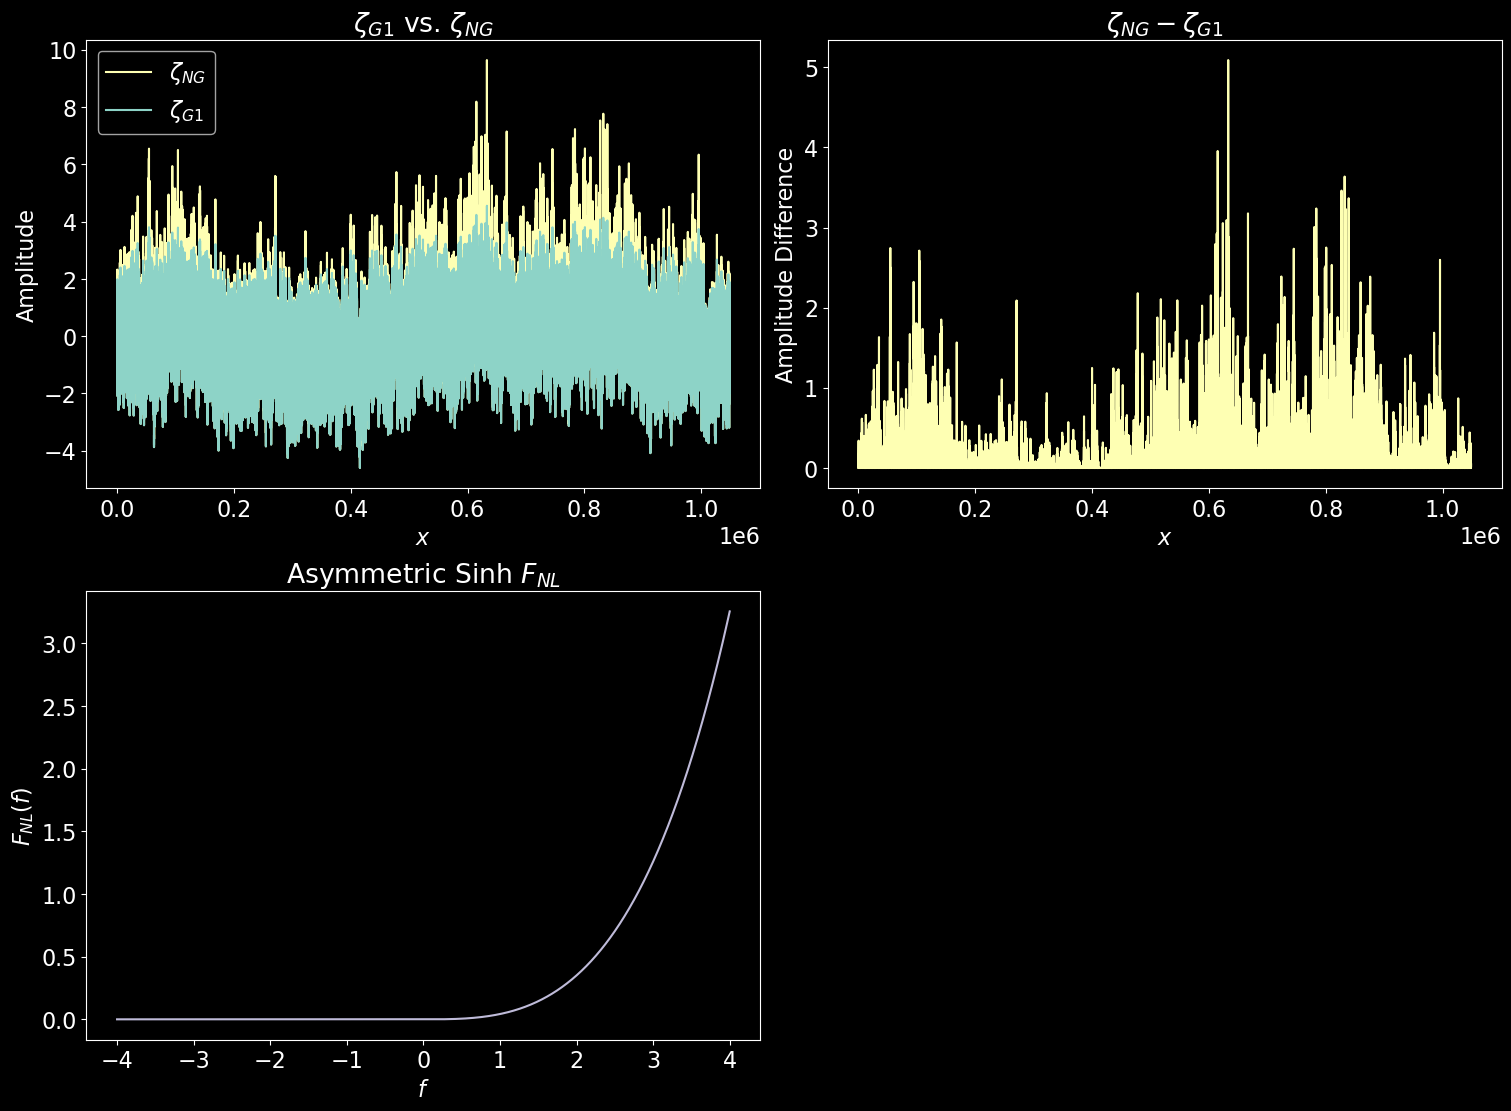

In [79]:
# Plot correlated G field, NG field, and F_nl

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 11), constrained_layout=True)

# fld_g = g
# fld_ng = zeta_NG_asymsinh
fld_xax = np.arange(0, N)
fld_diff = zeta_NG_asymsinh - g

ax1.set_title(r'$\zeta_{G1}$ vs. $\zeta_{NG}$')
ax1.plot(fld_xax, fld_ng, label=r'$\zeta_{NG}$', color='C1')
ax1.plot(fld_xax, fld_g, label=r'$\zeta_{G1}$')
ax1.legend(loc='upper left')
ax1.set(xlabel=r'$x$', ylabel="Amplitude")

ax2.set_title(r'$\zeta_{NG} - \zeta_{G1}$')
ax2.plot(fld_xax, fld_diff, color='C1')
ax2.set(xlabel=r'$x$', ylabel="Amplitude Difference")

ax3.set_title("Asymmetric Sinh "r'$F_{NL}$')
ax3.plot(tf, zeta_NG_asymsinh_test, label=r'$\zeta_{NG}$', color='C2')
ax3.set(xlabel=r'$f$', ylabel=r'$F_{NL}(f)$')

ax4.set_visible(False)

# plt.savefig('CorrNG_Fields.png')


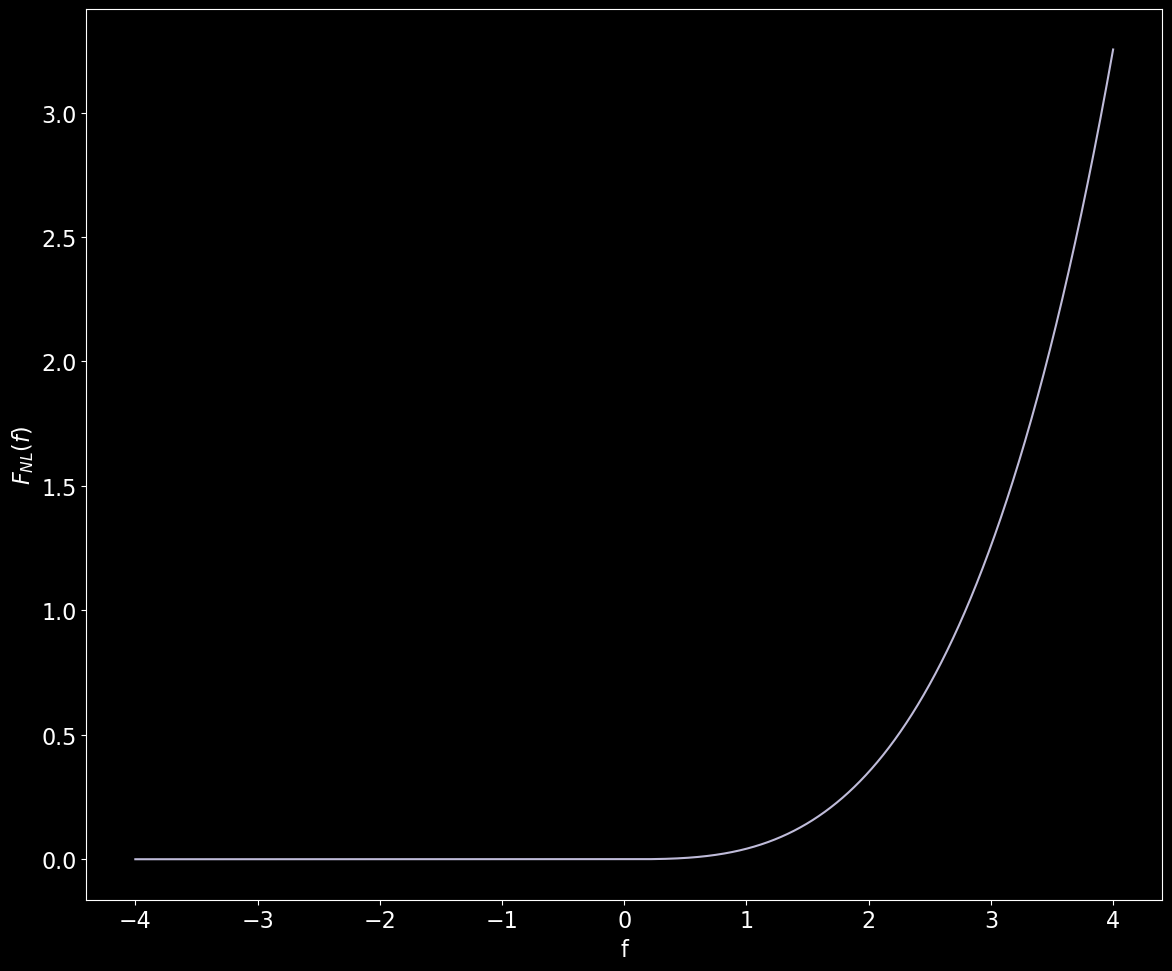

In [80]:
fig, ax = plt.subplots(1, figsize=(12, 10))

ax.plot(tf, zeta_NG_asymsinh_test, color='C2')
ax.set(xlabel="f", ylabel=r'$F_{NL}(f)$')
fig.tight_layout()


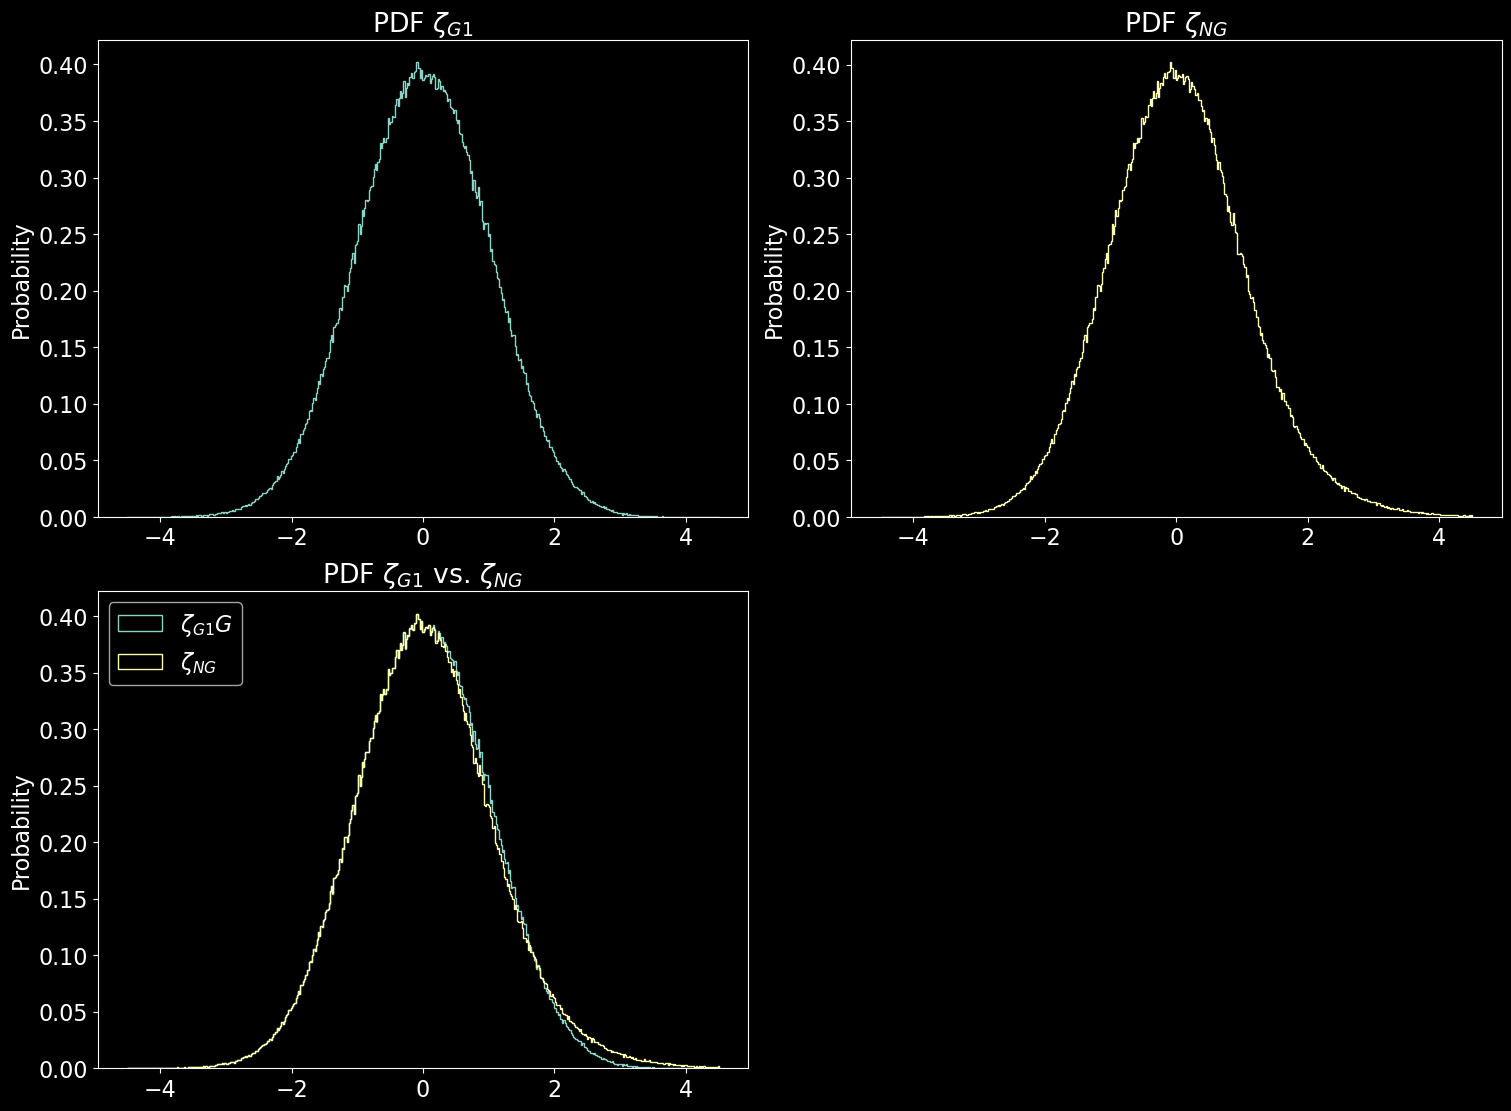

In [81]:
# Plot PDFs for correlated G and NG fields

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 11), constrained_layout=True)

# fld_g = g
# fld_ng = zeta_NG_asymsinh
hist_binvalues = np.linspace(-4.5, 4.5, 500)

ax1.set_title(r'PDF $\zeta_{G1}$')
ax1.hist(fld_g, bins=hist_binvalues, density=True, histtype='step')
ax1.set(ylabel="Probability")

ax2.set_title(r'PDF $\zeta_{NG}$')
ax2.hist(fld_ng, bins=hist_binvalues,
         density=True, histtype='step', color='C1')
ax2.set(ylabel="Probability")

ax3.set_title(r'PDF $\zeta_{G1}$ vs. $\zeta_{NG}$')
ax3.hist(fld_g, bins=hist_binvalues, density=True,
         label=r'$\zeta_{G1}G$', histtype='step')
ax3.hist(fld_ng, bins=hist_binvalues, density=True,
         label=r'$\zeta_{NG}$', histtype='step', color='C1')
ax3.legend(loc='upper left')
ax3.set(ylabel=r"Probability")

ax4.set_visible(False)

# plt.savefig('CorrNG_PDFs.png')

corr_g = fld_g
corr_ng = fld_ng


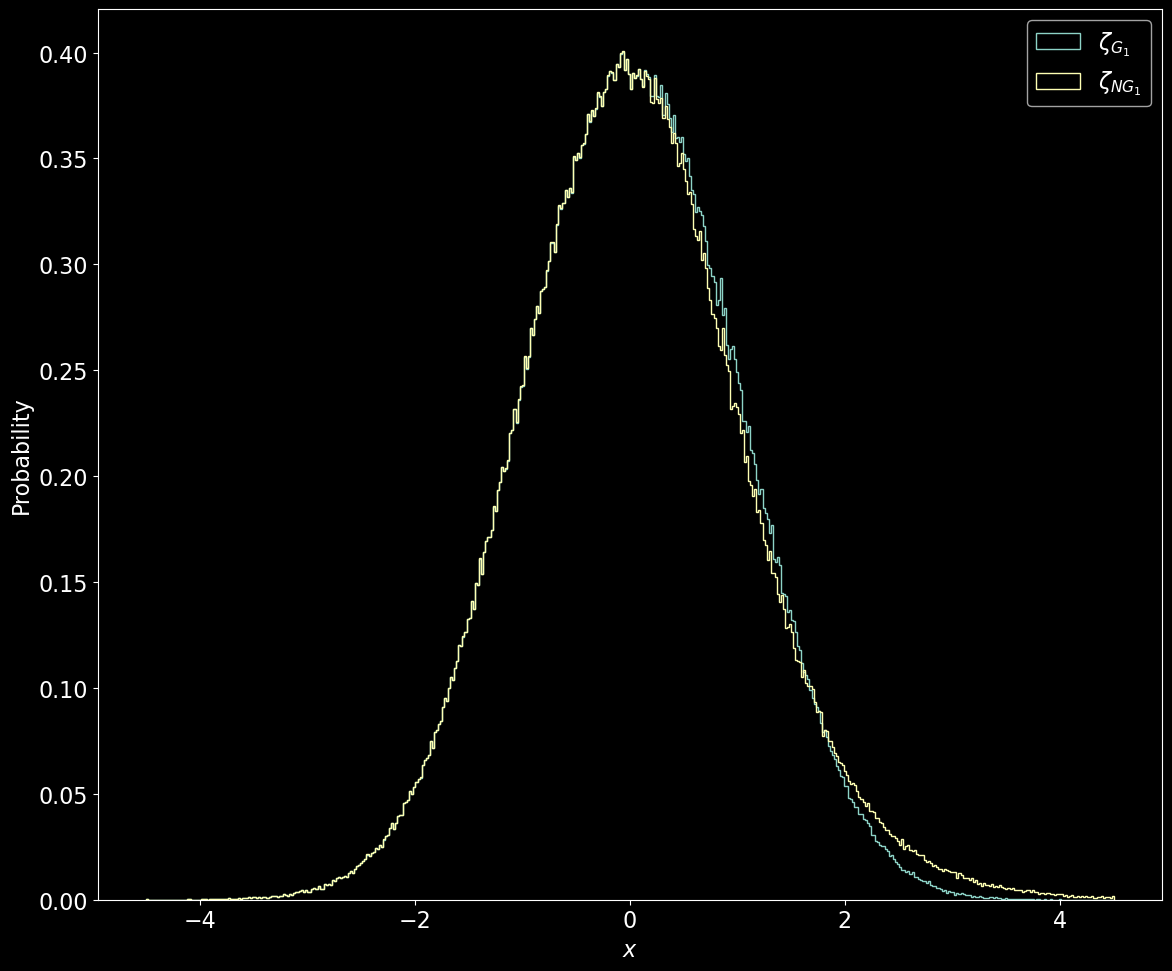

In [82]:
hist_binvalues = np.linspace(-4.5, 4.5, 475)
fig, ax = plt.subplots(1, figsize=(12, 10))

ax.hist(fld_g, bins=hist_binvalues, density=True,
        label=r'$\zeta_{G_1}$', histtype='step')
ax.hist(fld_ng, bins=hist_binvalues, density=True,
        label=r'$\zeta_{NG_1}$', histtype='step', color='C1')
ax.legend()
ax.set(ylabel=r"Probability")
ax.set(xlabel="$x$")
fig.tight_layout()


[ 0.95  2.85  4.75  6.65  8.55 10.45 12.35 14.25 16.15 18.05]


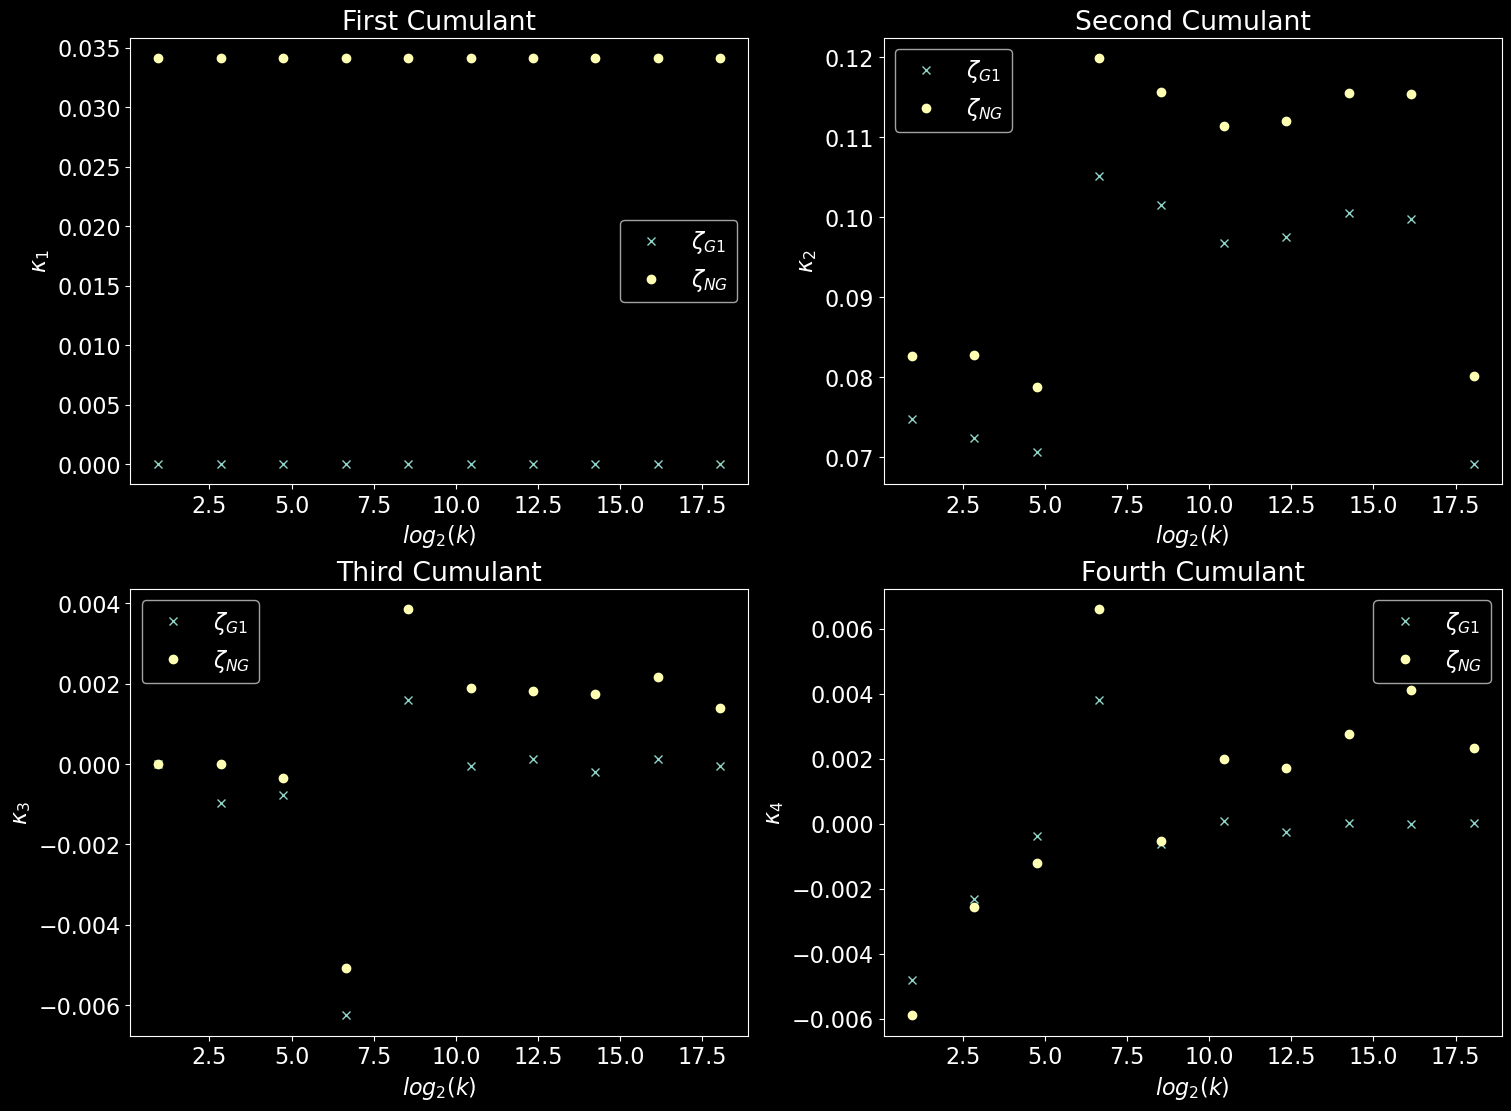

In [83]:
# Plot cumulants for correlated G and NG fields

fig, axs = plt.subplots(2, 2, figsize=(15, 11), constrained_layout=True)

# fld_g = g
# fld_ng = zeta_NG_asymsinh
cm_xax = log_k_bincentres
print(cm_xax)
gmark = 'x'
ngmark = 'o'

axs[0, 0].set_title(r'First Cumulant')
axs[0, 0].plot(cm_xax, cum_g[0, :], gmark, label=r'$\zeta_{G1}$')
axs[0, 0].plot(cm_xax, cum_ng[0, :], ngmark, label=r'$\zeta_{NG}$')
axs[0, 0].legend(loc='best')

axs[0, 1].set_title(r'Second Cumulant')
axs[0, 1].plot(cm_xax, cum_g[1, :], gmark, label=r'$\zeta_{G1}$')
axs[0, 1].plot(cm_xax, cum_ng[1, :], ngmark, label=r'$\zeta_{NG}$')
axs[0, 1].legend(loc='best')

axs[1, 0].set_title(r'Third Cumulant')
axs[1, 0].plot(cm_xax, cum_g[2, :], gmark, label=r'$\zeta_{G1}$')
axs[1, 0].plot(cm_xax, cum_ng[2, :], ngmark, label=r'$\zeta_{NG}$')
axs[1, 0].legend(loc='best')

axs[1, 1].set_title(r'Fourth Cumulant')
axs[1, 1].plot(cm_xax, cum_g[3, :], gmark, label=r'$\zeta_{G1}$')
axs[1, 1].plot(cm_xax, cum_ng[3, :], ngmark, label=r'$\zeta_{NG}$')
axs[1, 1].legend(loc='best')

k = 1
for ax in axs.flat:
    ax.set(xlabel=r'$log_{2}(k)$', ylabel=r'$\kappa_{{{0}}}$'.format(k))
    k += 1

# plt.savefig('CorrNG_cum.png')


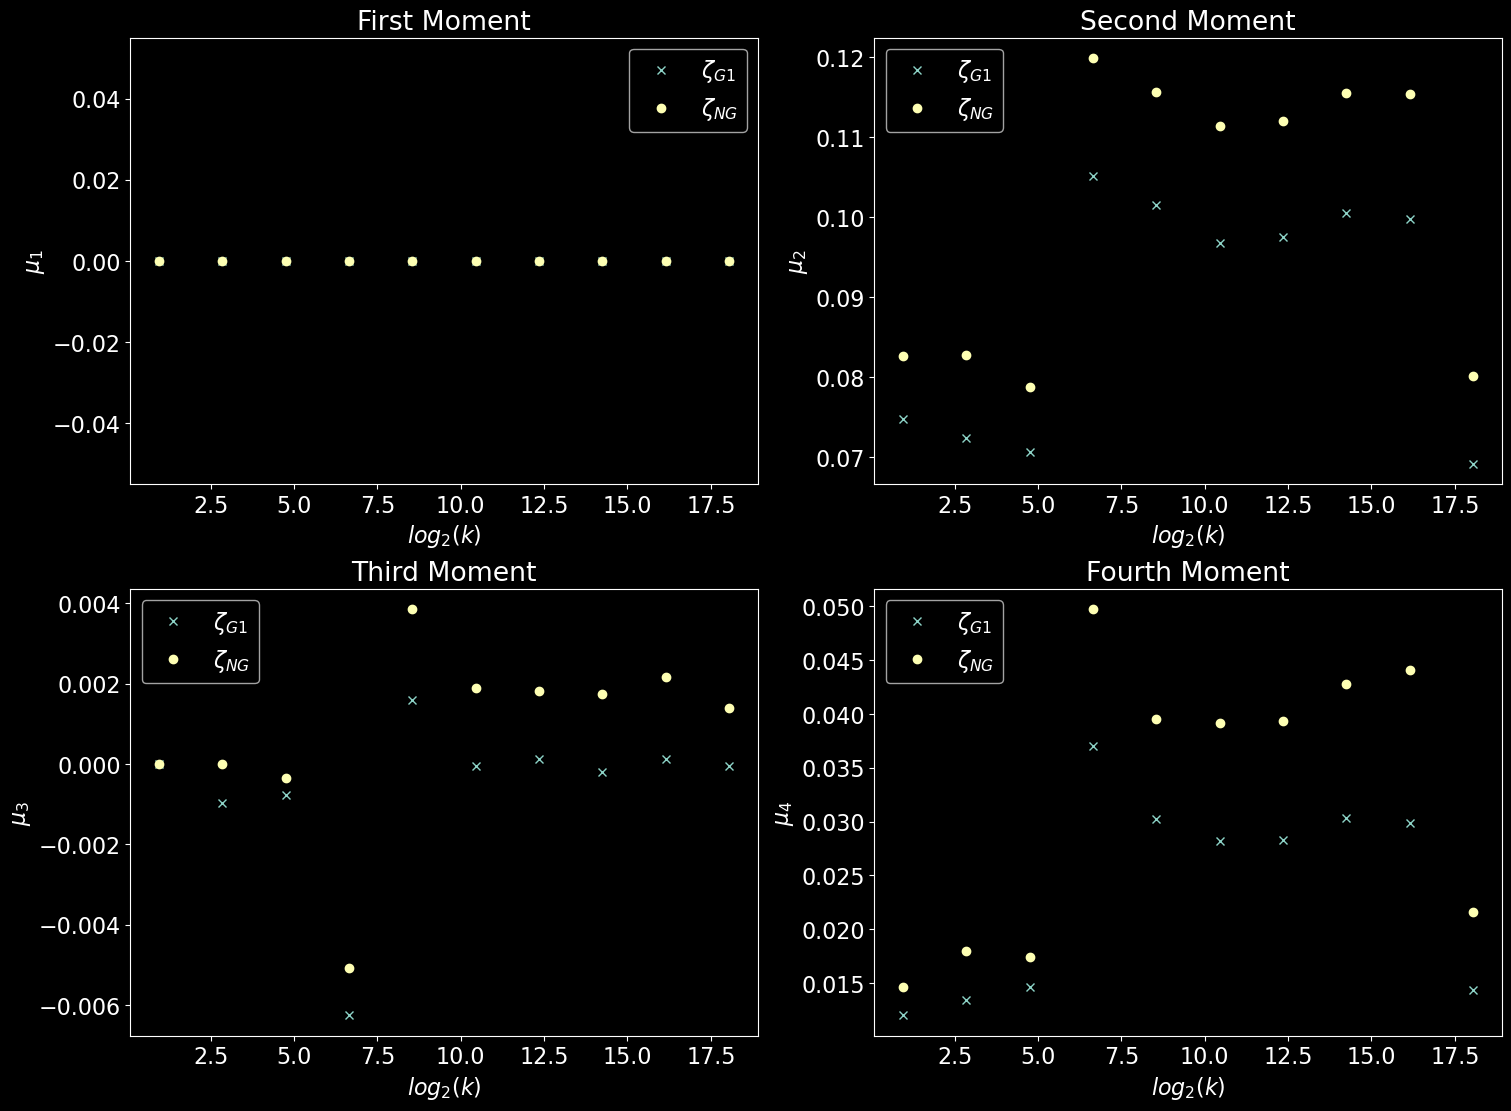

In [84]:
# Plot moments for correlated G and NG fields

fig, axs = plt.subplots(2, 2, figsize=(15, 11), constrained_layout=True)

# fld_g = g
# fld_ng = zeta_NG_asymsinh
cm_xax = log_k_bincentres
gmark = 'x'
ngmark = 'o'

axs[0, 0].set_title(r'First Moment')
axs[0, 0].plot(cm_xax, mom_g[0, :], gmark, label=r'$\zeta_{G1}$')
axs[0, 0].plot(cm_xax, mom_ng[0, :], ngmark, label=r'$\zeta_{NG}$')
axs[0, 0].legend(loc='best')

axs[0, 1].set_title(r'Second Moment')
axs[0, 1].plot(cm_xax, mom_g[1, :], gmark, label=r'$\zeta_{G1}$')
axs[0, 1].plot(cm_xax, mom_ng[1, :], ngmark, label=r'$\zeta_{NG}$')
axs[0, 1].legend(loc='best')

axs[1, 0].set_title(r'Third Moment')
axs[1, 0].plot(cm_xax, mom_g[2, :], gmark, label=r'$\zeta_{G1}$')
axs[1, 0].plot(cm_xax, mom_ng[2, :], ngmark, label=r'$\zeta_{NG}$')
axs[1, 0].legend(loc='best')

axs[1, 1].set_title(r'Fourth Moment')
axs[1, 1].plot(cm_xax, mom_g[3, :], gmark, label=r'$\zeta_{G1}$')
axs[1, 1].plot(cm_xax, mom_ng[3, :], ngmark, label=r'$\zeta_{NG}$')
axs[1, 1].legend(loc='best')

k = 1
for ax in axs.flat:
    ax.set(xlabel=r'$log_{2}(k)$', ylabel=r'$\mu_{{{0}}}$'.format(k))
    k += 1

# plt.savefig('CorrNG_mom.png')


## Calculate and plot moments/cumulants for UNCORRELATED NG field

In [85]:
# Smooth the correlated nonG field and calculate cumulants and moments (1 to 4) in each band

# kc = np.arange(1, N//2+1, step=1000)
# kw = np.ones(np.shape(kc)) * 10
nbins = 10
kc = np.geomspace(1, N//2, num=nbins+1)
# np.geomspace
print(kc.size)
kc_size = kc.size
fld_g = g
fld_ng = zeta_NG_asymsinh_uncorr

cum_g = np.zeros((4, nbins))
cum_ng = np.zeros((4, nbins))
mom_g = np.zeros((4, nbins))
mom_ng = np.zeros((4, nbins))

zeta_smooth_grf = np.zeros((kc_size, N))
zeta_smooth = np.zeros((kc_size, N))
zeta_smooth_ln = np.zeros((kc_size, N))

for i in np.arange(0, nbins):
    # Smoothing the correlated data with a top-hat window function
    zeta_smooth_grf[i] = flt.window_tophat(fld_g, N, kc[i], kc[i+1])
    zeta_smooth[i] = flt.window_tophat(fld_ng, N, kc[i], kc[i+1])
#     zeta_smooth_ln[i], W_inv = flt.window_tophat_gauss_ln(zeta_NG_asymsinh, N, k, kw[i])

    # Calculating cumulants and moments for the smoothed data
    cum_ng[0, i] = stats.kstat(zeta_smooth[i], n=1)
    cum_g[0, i] = stats.kstat(zeta_smooth_grf[i], n=1)
    mom_ng[0, i] = stats.moment(zeta_smooth[i], moment=1)
    mom_g[0, i] = stats.moment(zeta_smooth_grf[i], moment=1)

    cum_ng[1, i] = stats.kstat(zeta_smooth[i], n=2)
    cum_g[1, i] = stats.kstat(zeta_smooth_grf[i], n=2)
    mom_ng[1, i] = stats.moment(zeta_smooth[i], moment=2)
    mom_g[1, i] = stats.moment(zeta_smooth_grf[i], moment=2)

    cum_ng[2, i] = stats.kstat(zeta_smooth[i], n=3)
    cum_g[2, i] = stats.kstat(zeta_smooth_grf[i], n=3)
    mom_ng[2, i] = stats.moment(zeta_smooth[i], moment=3)
    mom_g[2, i] = stats.moment(zeta_smooth_grf[i], moment=3)

    cum_ng[3, i] = stats.kstat(zeta_smooth[i], n=4)
    cum_g[3, i] = stats.kstat(zeta_smooth_grf[i], n=4)
    mom_ng[3, i] = stats.moment(zeta_smooth[i], moment=4)
    mom_g[3, i] = stats.moment(zeta_smooth_grf[i], moment=4)


11


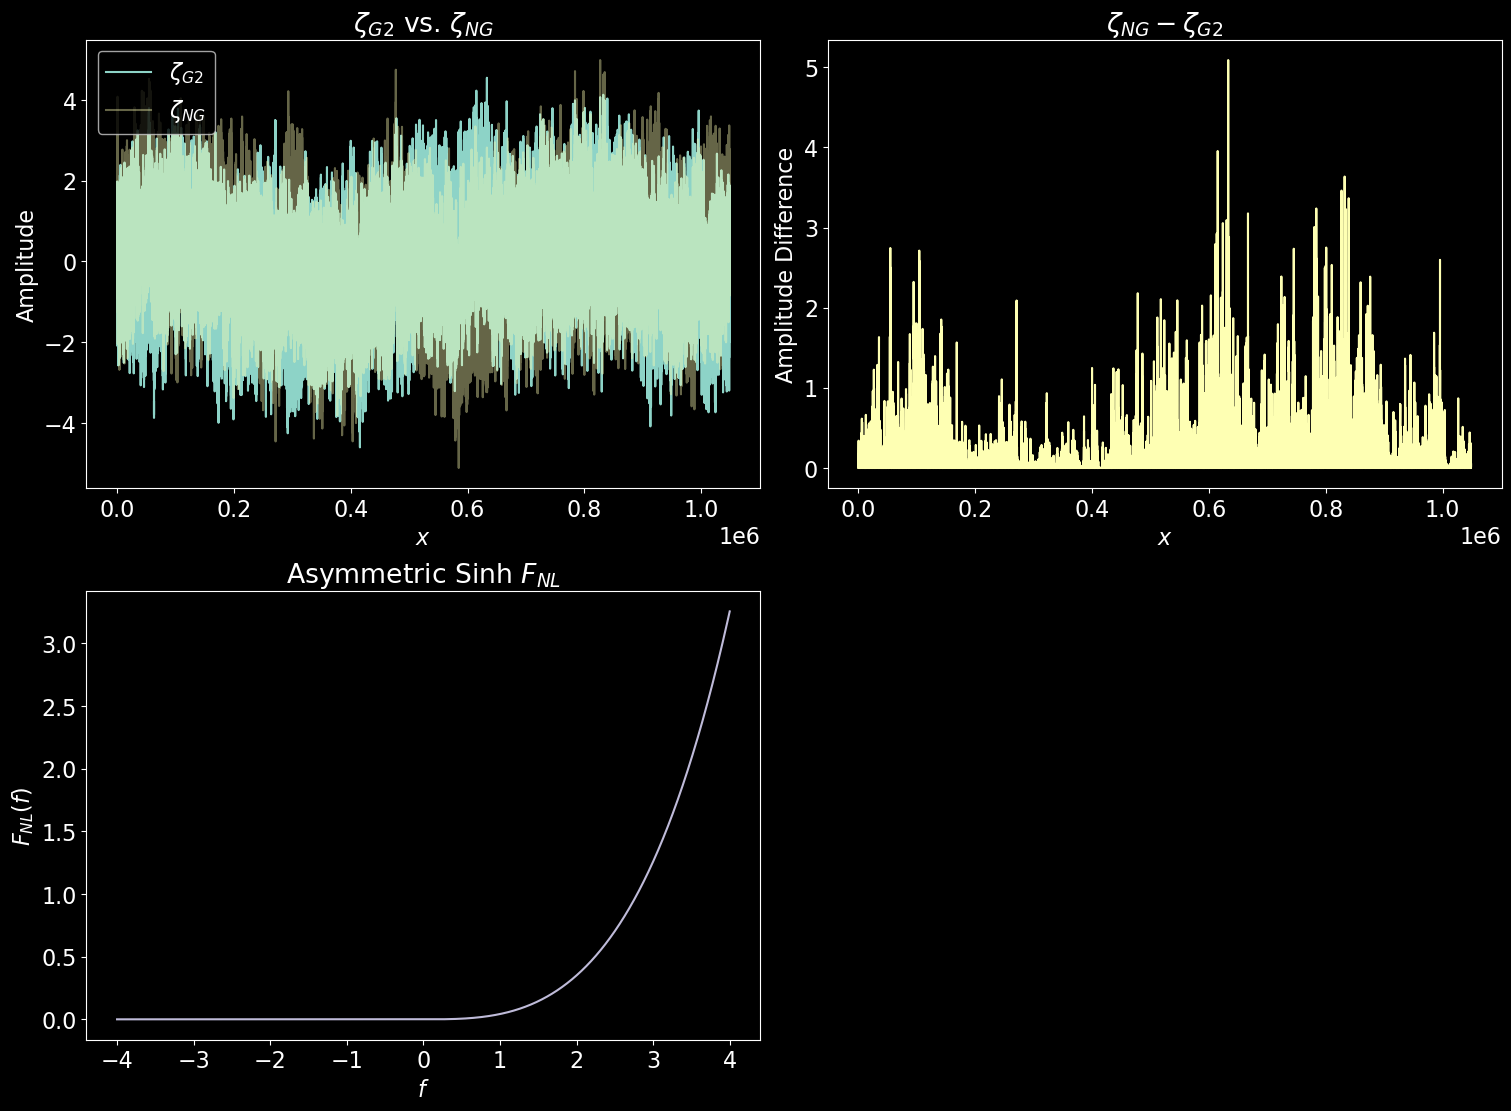

In [86]:
# Plot uncorrelated G field, NG field, and F_nl

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 11), constrained_layout=True)

# fld_g = g
# fld_ng = zeta_NG_asymsinh
fld_xax = np.arange(0, N)
fld_diff = zeta_NG_asymsinh - g
transp = 0.4

ax1.set_title(r'$\zeta_{G2}$ vs. $\zeta_{NG}$')
ax1.plot(fld_xax, fld_g, label=r'$\zeta_{G2}$')
ax1.plot(fld_xax, fld_ng, label=r'$\zeta_{NG}$', alpha=transp, color='C1')
ax1.legend(loc='upper left')
ax1.set(xlabel=r'$x$', ylabel="Amplitude")

ax2.set_title(r'$\zeta_{NG} - \zeta_{G2}$')
ax2.plot(fld_xax, fld_diff, color='C1')
ax2.set(xlabel=r'$x$', ylabel="Amplitude Difference")

ax3.set_title("Asymmetric Sinh "r'$F_{NL}$')
ax3.plot(tf, zeta_NG_asymsinh_test, label=r'$\zeta_{NG}$', color='C2')
ax3.set(xlabel=r'$f$', ylabel=r'$F_{NL}(f)$')

ax4.set_visible(False)

# plt.savefig('UncorrNG_Fields.png')


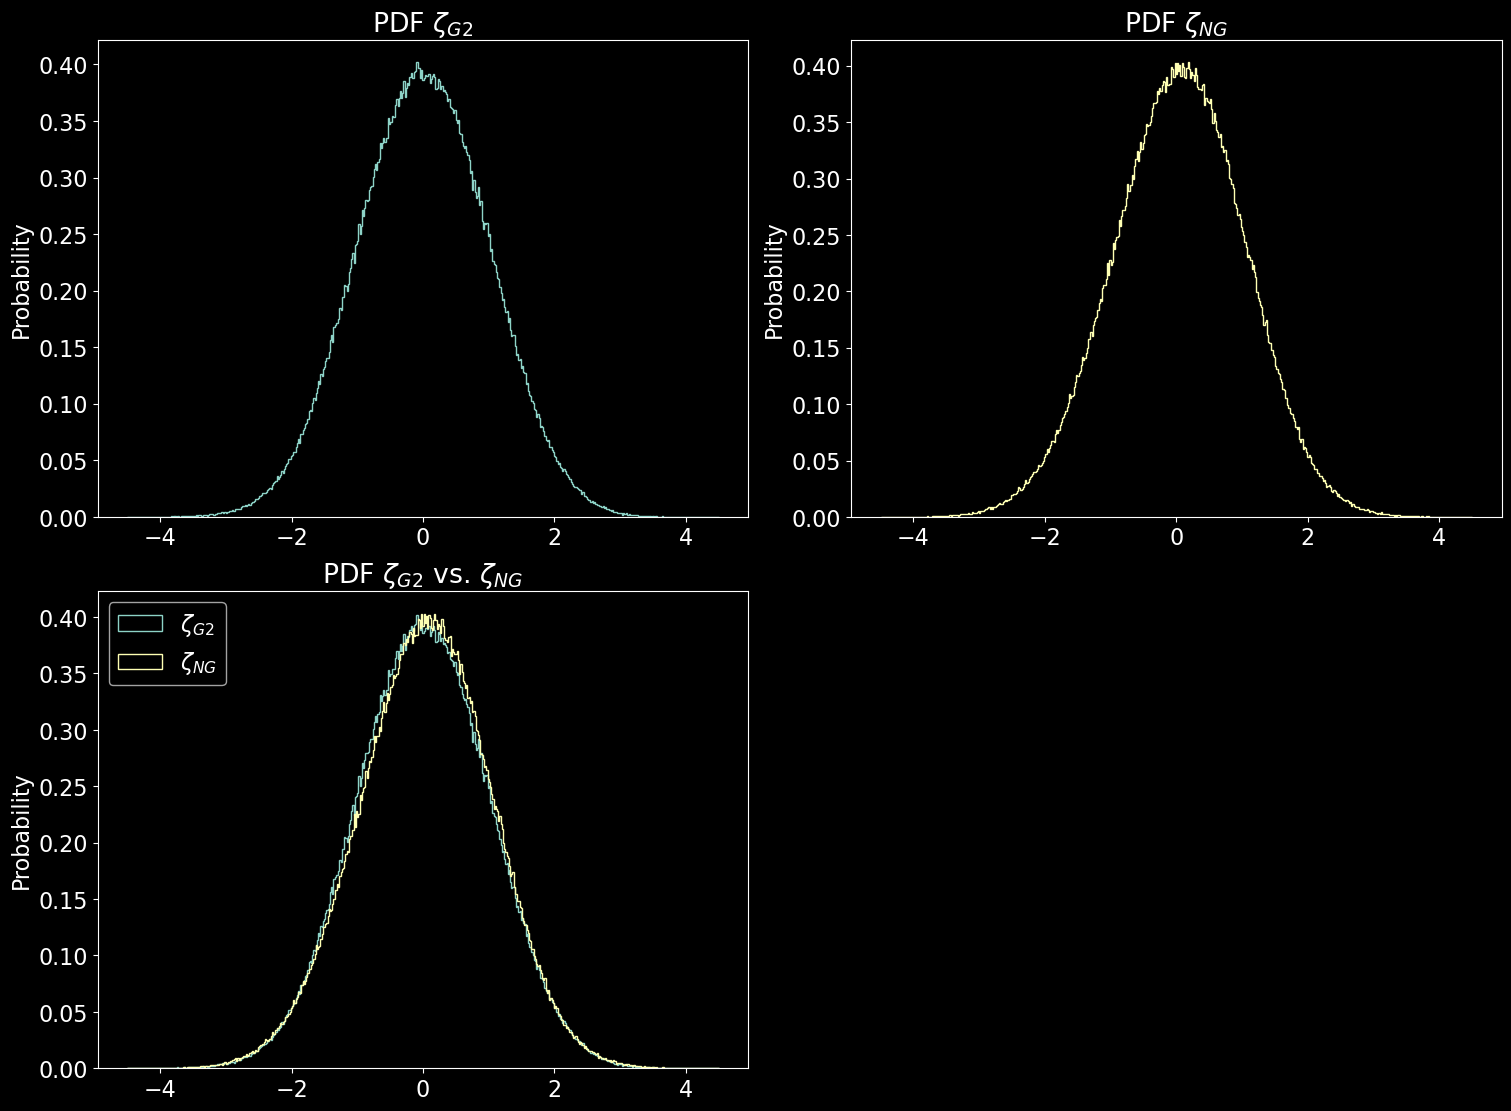

In [87]:
# Plot PDFs for uncorrelated G and NG fields

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 11), constrained_layout=True)

# fld_g = g
# fld_ng = zeta_NG_asymsinh
hist_binvalues = np.linspace(-4.5, 4.5, 500)

ax1.set_title(r'PDF $\zeta_{G2}$')
ax1.hist(fld_g, bins=hist_binvalues, density=True, histtype='step')
ax1.set(ylabel="Probability")

ax2.set_title(r'PDF $\zeta_{NG}$')
ax2.hist(fld_ng, bins=hist_binvalues,
         density=True, histtype='step', color='C1')
ax2.set(ylabel="Probability")

ax3.set_title(r'PDF $\zeta_{G2}$ vs. $\zeta_{NG}$')
ax3.hist(fld_g, bins=hist_binvalues, density=True,
         label=r'$\zeta_{G2}$', histtype='step')
ax3.hist(fld_ng, bins=hist_binvalues, density=True,
         label=r'$\zeta_{NG}$', histtype='step', color='C1')
ax3.legend(loc='upper left')
ax3.set(ylabel=r"Probability")

ax4.set_visible(False)

# plt.savefig('UncorrNG_PDFs.png')


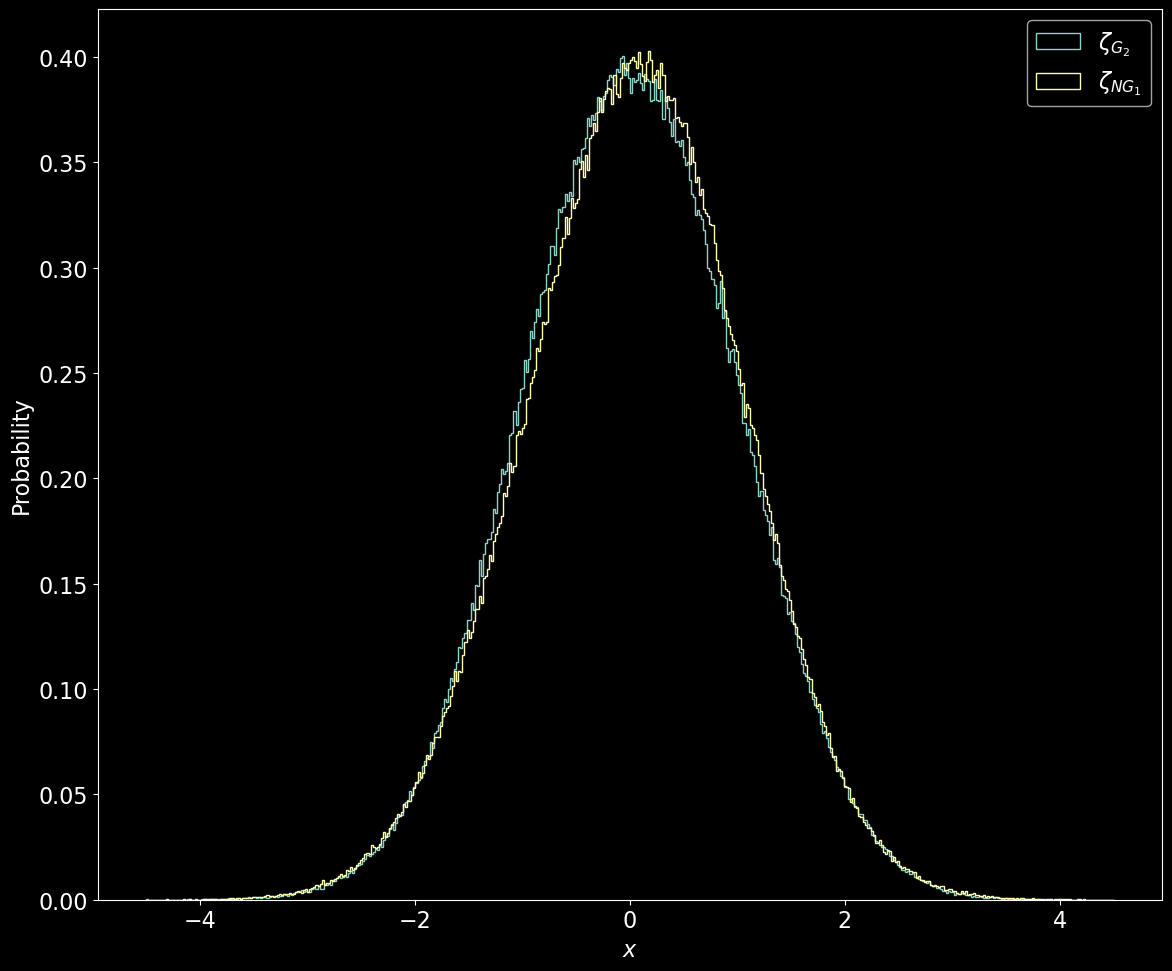

In [88]:
hist_binvalues = np.linspace(-4.5, 4.5, 475)
fig, ax = plt.subplots(1, figsize=(12, 10))

ax.hist(fld_g, bins=hist_binvalues, density=True,
        label=r'$\zeta_{G_2}$', histtype='step')
ax.hist(fld_ng, bins=hist_binvalues, density=True,
        label=r'$\zeta_{NG_1}$', histtype='step', color='C1')
ax.legend()
ax.set(ylabel=r"Probability")
ax.set(xlabel="$x$")
fig.tight_layout()


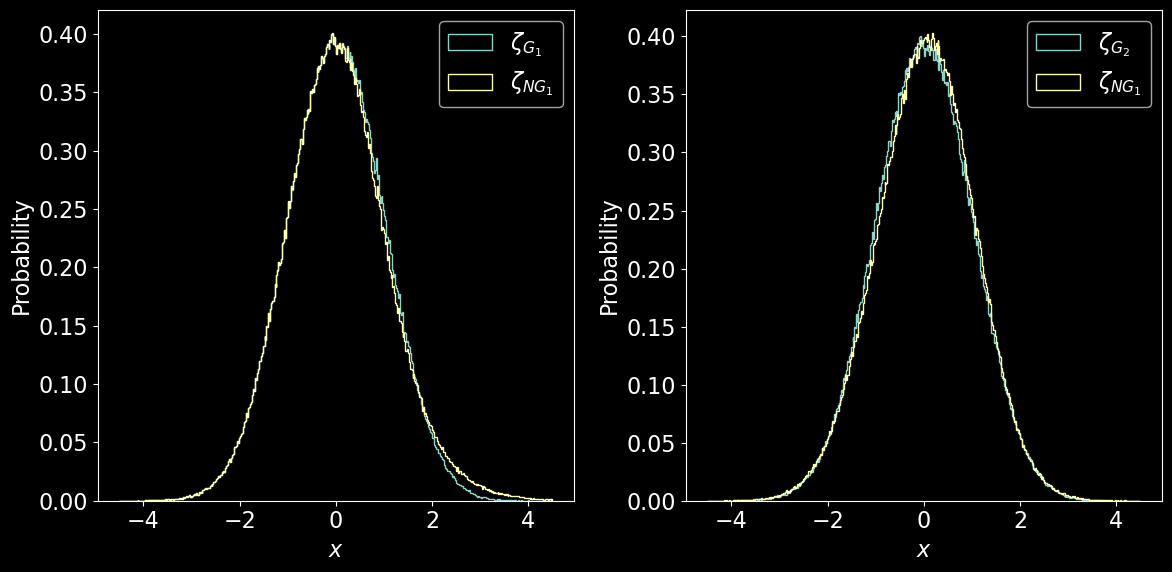

In [89]:
hist_binvalues = np.linspace(-4.5, 4.5, 475)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(corr_g, bins=hist_binvalues, density=True,
           label=r'$\zeta_{G_1}$', histtype='step')
ax[0].hist(corr_ng, bins=hist_binvalues, density=True,
           label=r'$\zeta_{NG_1}$', histtype='step', color='C1')
ax[0].legend()
ax[0].set(ylabel=r"Probability")
ax[0].set(xlabel="$x$")

ax[1].hist(fld_g, bins=hist_binvalues, density=True,
           label=r'$\zeta_{G_2}$', histtype='step')
ax[1].hist(fld_ng, bins=hist_binvalues, density=True,
           label=r'$\zeta_{NG_1}$', histtype='step', color='C1')
ax[1].legend()
ax[1].set(ylabel=r"Probability")
ax[1].set(xlabel="$x$")

fig.tight_layout()


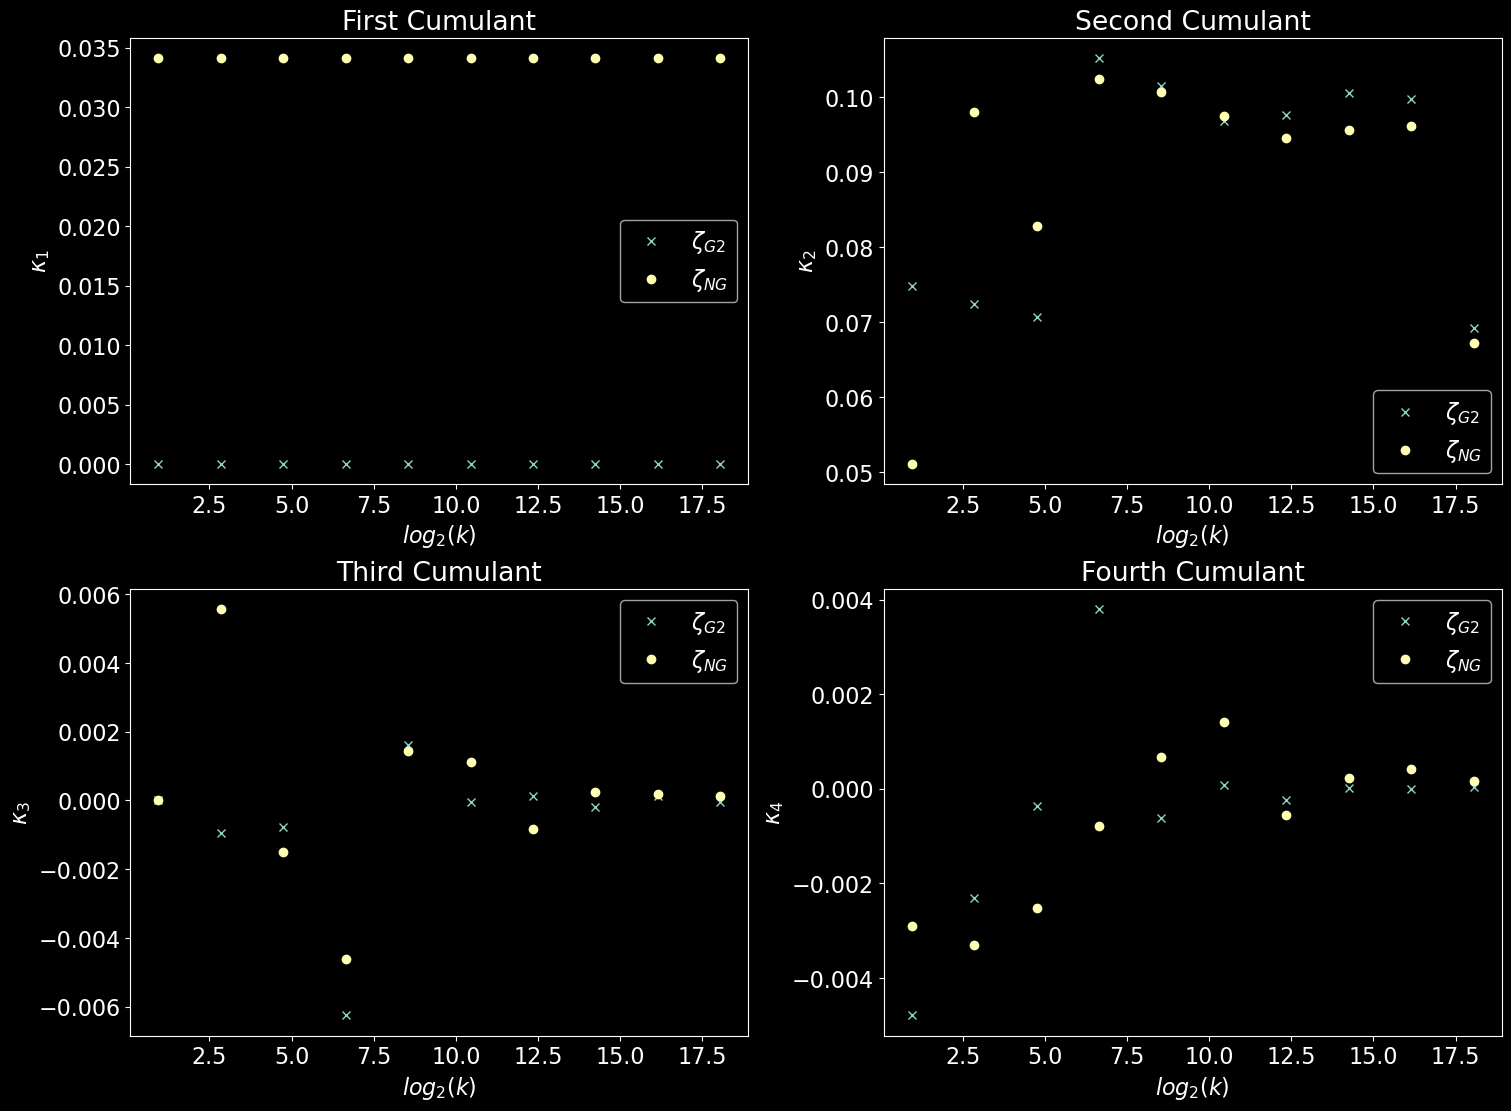

In [90]:
# Plot cumulants for uncorrelated G and NG fields

fig, axs = plt.subplots(2, 2, figsize=(15, 11), constrained_layout=True)

# fld_g = g
# fld_ng = zeta_NG_asymsinh
cm_xax = log_k_bincentres
gmark = 'x'
ngmark = 'o'

axs[0, 0].set_title(r'First Cumulant')
axs[0, 0].plot(cm_xax, cum_g[0, :], gmark, label=r'$\zeta_{G2}$')
axs[0, 0].plot(cm_xax, cum_ng[0, :], ngmark, label=r'$\zeta_{NG}$')
axs[0, 0].legend(loc='best')

axs[0, 1].set_title(r'Second Cumulant')
axs[0, 1].plot(cm_xax, cum_g[1, :], gmark, label=r'$\zeta_{G2}$')
axs[0, 1].plot(cm_xax, cum_ng[1, :], ngmark, label=r'$\zeta_{NG}$')
axs[0, 1].legend(loc='best')

axs[1, 0].set_title(r'Third Cumulant')
axs[1, 0].plot(cm_xax, cum_g[2, :], gmark, label=r'$\zeta_{G2}$')
axs[1, 0].plot(cm_xax, cum_ng[2, :], ngmark, label=r'$\zeta_{NG}$')
axs[1, 0].legend(loc='best')

axs[1, 1].set_title(r'Fourth Cumulant')
axs[1, 1].plot(cm_xax, cum_g[3, :], gmark, label=r'$\zeta_{G2}$')
axs[1, 1].plot(cm_xax, cum_ng[3, :], ngmark, label=r'$\zeta_{NG}$')
axs[1, 1].legend(loc='best')

k = 1
for ax in axs.flat:
    ax.set(xlabel=r'$log_{2}(k)$', ylabel=r'$\kappa_{{{0}}}$'.format(k))
    k += 1

# plt.savefig('UncorrNG_cum.png')


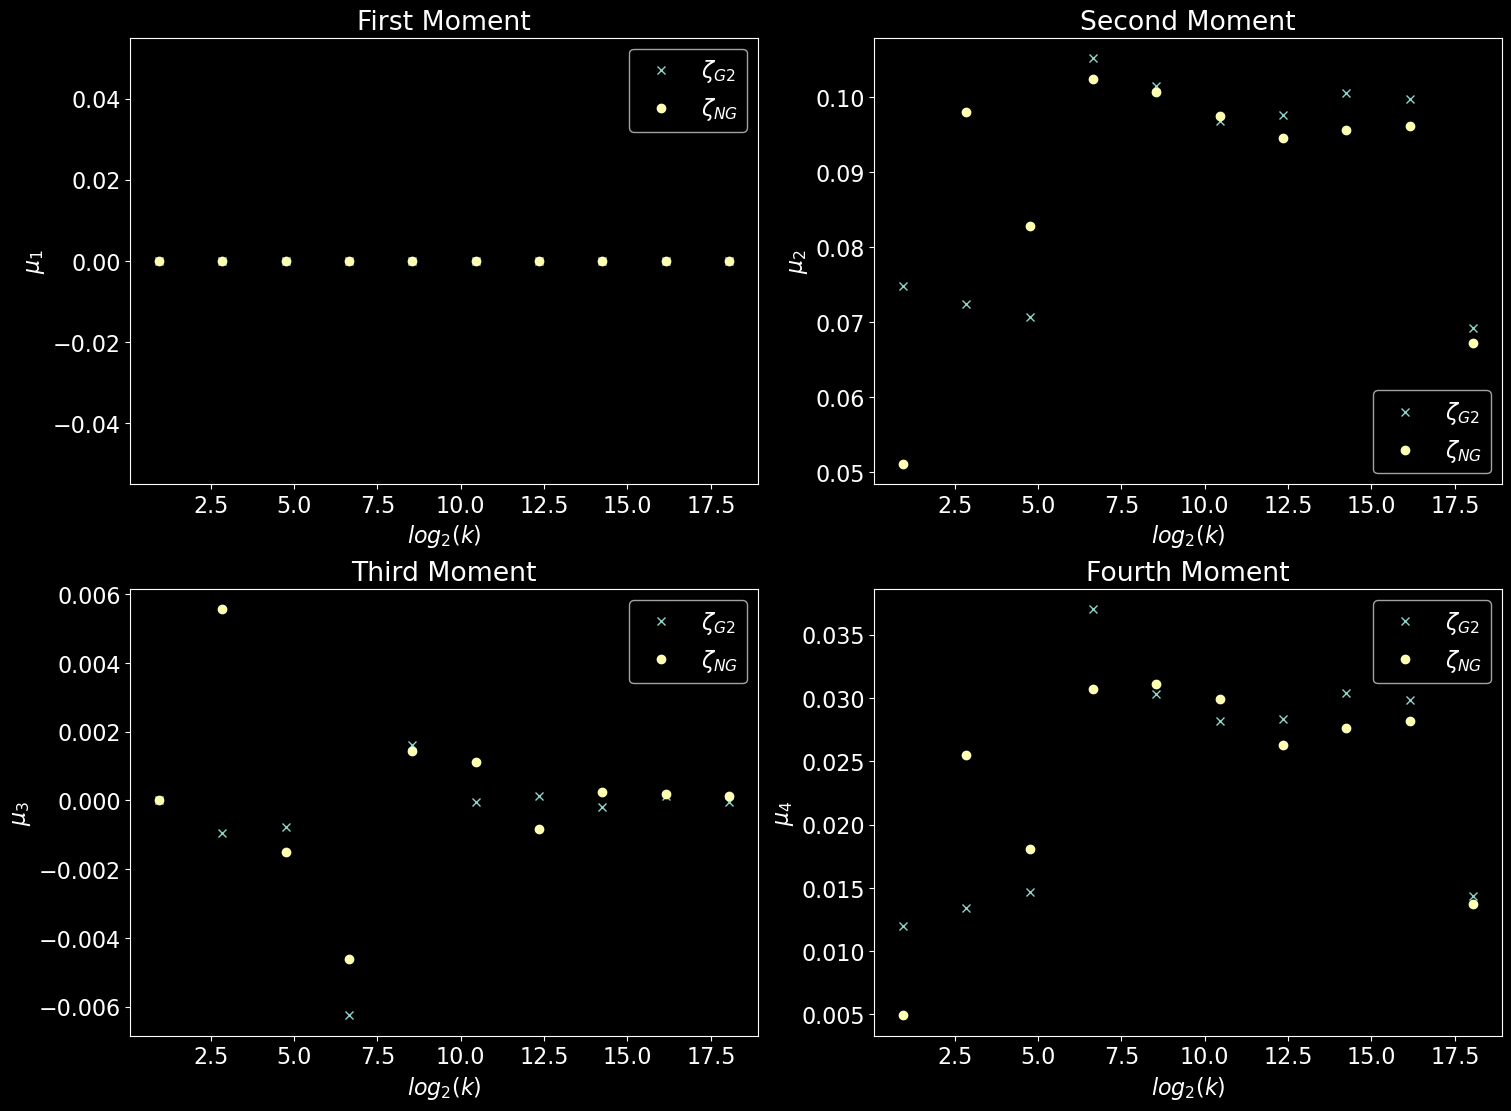

In [91]:
# Plot moments for uncorrelated G and NG fields

fig, axs = plt.subplots(2, 2, figsize=(15, 11), constrained_layout=True)

# fld_g = g
# fld_ng = zeta_NG_asymsinh
cm_xax = log_k_bincentres
gmark = 'x'
ngmark = 'o'

axs[0, 0].set_title(r'First Moment')
axs[0, 0].plot(cm_xax, mom_g[0, :], gmark, label=r'$\zeta_{G2}$')
axs[0, 0].plot(cm_xax, mom_ng[0, :], ngmark, label=r'$\zeta_{NG}$')
axs[0, 0].legend(loc='best')

axs[0, 1].set_title(r'Second Moment')
axs[0, 1].plot(cm_xax, mom_g[1, :], gmark, label=r'$\zeta_{G2}$')
axs[0, 1].plot(cm_xax, mom_ng[1, :], ngmark, label=r'$\zeta_{NG}$')
axs[0, 1].legend(loc='best')

axs[1, 0].set_title(r'Third Moment')
axs[1, 0].plot(cm_xax, mom_g[2, :], gmark, label=r'$\zeta_{G2}$')
axs[1, 0].plot(cm_xax, mom_ng[2, :], ngmark, label=r'$\zeta_{NG}$')
axs[1, 0].legend(loc='best')

axs[1, 1].set_title(r'Fourth Moment')
axs[1, 1].plot(cm_xax, mom_g[3, :], gmark, label=r'$\zeta_{G2}$')
axs[1, 1].plot(cm_xax, mom_ng[3, :], ngmark, label=r'$\zeta_{NG}$')
axs[1, 1].legend(loc='best')

k = 1
for ax in axs.flat:
    ax.set(xlabel=r'$log_{2}(k)$', ylabel=r'$\mu_{{{0}}}$'.format(k))
    k += 1

# plt.savefig('UncorrNG_mom.png')
